In [203]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Concatenate, Dense
from tensorflow.keras.models import Model
from sklearn.linear_model import LinearRegression
import kagglehub
import re


In [204]:
# Load dataset (example: historical ticket pricing data)
path = kagglehub.dataset_download("ibrahimelsayed182/plane-ticket-price")
print("Path to dataset files:", path)
data_path = fr'{path}\ticket_pricing_data.csv'
raw = pd.read_csv(r'C:\Users\Alex\.cache\kagglehub\datasets\ibrahimelsayed182\plane-ticket-price\versions\1\Data_Train.csv')


Path to dataset files: C:\Users\Alex\.cache\kagglehub\datasets\ibrahimelsayed182\plane-ticket-price\versions\1


In [205]:
raw.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [206]:


def convert_to_minutes(duration):
    # Extract hours and minutes using regex
    hours = re.search(r'(\d+)h', duration)
    minutes = re.search(r'(\d+)m', duration)
    
    # Convert to integer values, defaulting to 0 if missing
    total_minutes = (int(hours.group(1)) * 60 if hours else 0) + (int(minutes.group(1)) if minutes else 0)
    
    return total_minutes

def clean_and_convert_time(time_str):
    if isinstance(time_str, str) and ' ' in time_str:  # Check if it's a string and contains a space
        return None  # Or assign a default time like '00:00'
    try:
        return pd.to_datetime(time_str, format='%H:%M', errors='coerce')
    except Exception:
        return None  # If conversion fails, return None

def preprocess_date_and_time(data):
    # Preprocessing Date and Time columns
    data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], format='%d/%m/%Y')
    data['Journey_day'] = data['Date_of_Journey'].dt.day
    data['Journey_month'] = data['Date_of_Journey'].dt.month

    data['Dep_Time'] = data['Dep_Time'].apply(clean_and_convert_time)
    data['Dep_hour'] = data['Dep_Time'].dt.hour
    data['Dep_minute'] = data['Dep_Time'].dt.minute

    data['Arrival_Time'] = data['Arrival_Time'].apply(clean_and_convert_time)
    data['Arrival_hour'] = data['Arrival_Time'].dt.hour
    data['Arrival_minute'] = data['Arrival_Time'].dt.minute

    return data

def encode_categorical_features(data, categorical_columns):
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le  # Save label encoder for possible inverse transformation later
    return data, label_encoders

def normalize_numerical_columns(data, numerical_columns, scaler=None):
    if not scaler:
        scaler = StandardScaler()
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
    return data, scaler

def map_total_stops(data):
    stops_mapping = {
        'non-stop': 0,
        '1 stop': 1,
        '2 stops': 2,
        '3 stops': 3,
        '4 stops': 4
    }
    data['Total_Stops'] = data['Total_Stops'].map(stops_mapping)
    if data['Total_Stops'].isnull().any():
        print("Warning: There are NaN values in the 'Total_Stops' column after mapping.")
    return data

def preprocess_data(raw):
    data = raw.copy()

    # Apply function to the column
    data['Duration'] = data['Duration'].apply(convert_to_minutes)

    # Preprocess date and time columns
    data = preprocess_date_and_time(data)

    # Handle categorical features
    categorical_columns = ['Airline', 'Source', 'Destination', 'Route', 'Additional_Info']
    data, label_encoders = encode_categorical_features(data, categorical_columns)

    # Normalize numerical columns
    numerical_columns = ['Journey_day', 'Journey_month', 'Dep_hour', 'Dep_minute', 'Arrival_hour', 'Arrival_minute', 'Duration']
    data, scaler = normalize_numerical_columns(data, numerical_columns)

    # Map Total_Stops
    data = map_total_stops(data)

    # Separate features and target variable
    X = data.drop(['Price', 'Date_of_Journey', 'Dep_Time', 'Arrival_Time'], axis=1)
    y = data['Price']

    return X, y, label_encoders, scaler

# Example usage:
X, y, label_encoders, scaler = preprocess_data(raw)

In [207]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [208]:
def create_model_1(input_shape):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Output price
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model


In [209]:
def create_model_2(input_shape):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Output price
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model


In [210]:
def create_model_3(input_shape):
    model = models.Sequential([
        layers.Reshape((input_shape[0], 1), input_shape=input_shape),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # Output price
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model


In [211]:
input_shape = (X_train.shape[1],)  # Shape of the input features

model1_nn = create_model_1(input_shape)
model2_nn = create_model_2(input_shape)
model3_nn = create_model_3(input_shape)



# Train the nn models
models_list = [model1_nn, model2_nn, model3_nn]
for i, model in enumerate(models_list):
    print(f"Training Model {i+1}...")
    model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Training Model 1...
Epoch 1/10


c:\Projects\DataSci\.mlws\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Projects\DataSci\.mlws\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9019.1309 - val_loss: 9135.5410
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9030.3291 - val_loss: 9134.5186
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9053.5791 - val_loss: 9132.6631
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9071.5195 - val_loss: 9129.9238
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9092.8848 - val_loss: 9126.3340
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8954.5840 - val_loss: 9121.9443
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9142.4473 - val_loss: 9116.8027
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9145.5527 - val_loss: 9110.9541
Epoch 9/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9018.1104 - val_loss: 9104.4346
Epoch 10/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9079.7520 - val_loss: 9097.2793
Training Model 2...
Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9024.3271 

In [212]:
def averaging_ensemble(models, input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    outputs = [model(inputs) for model in models]
    avg_output = tf.keras.layers.Average()(outputs)
    ensemble_model = tf.keras.Model(inputs=inputs, outputs=avg_output)
    return ensemble_model

ensemble_avg = averaging_ensemble(models_list, input_shape)
ensemble_avg.compile(optimizer='adam', loss='mean_absolute_error')

# Evaluate the ensemble model
ensemble_avg.evaluate(X_test, y_test)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7274.7300


7200.3330078125

In [213]:


def stacking_ensemble(models, input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    outputs = [model(inputs) for model in models]
    concatenated = Concatenate()(outputs)
    
    meta_output = Dense(1)(concatenated)
    stacked_model = Model(inputs=inputs, outputs=meta_output)
    return stacked_model

ensemble_stack = stacking_ensemble(models_list, input_shape)
ensemble_stack.compile(optimizer='adam', loss='mean_absolute_error')

# Evaluate stacking model
ensemble_stack.evaluate(X_test, y_test)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12742.4873 


12668.08203125

In [214]:
# Predictions for ensemble models
y_pred_nn_avg = ensemble_avg.predict(X_test)
y_pred_stack = ensemble_stack.predict(X_test)

# Calculate MAE for both models
mae_avg = mean_absolute_error(y_test, y_pred_nn_avg)
mae_stack = mean_absolute_error(y_test, y_pred_stack)

print(f"MAE of Averaging Ensemble: {mae_avg}")
print(f"MAE of Stacking Ensemble: {mae_stack}")


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE of Averaging Ensemble: 7200.32666015625
MAE of Stacking Ensemble: 12668.083984375


In [215]:
# Train Random Forest
def create_rf_model():
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    return rf_model

# Train XGBoost
def create_xgb_model():
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    return xgb_model

rf_model = create_rf_model()
xgb_model = create_xgb_model()

# Train Random Forest
rf_model.fit(X_train, y_train)

# Train XGBoost
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [216]:


y_pred_rf = rf_model.predict(X_test).reshape(-1, 1)
y_pred_xgb = xgb_model.predict(X_test).reshape(-1, 1)

# Stack predictions together
meta_predictions = np.mean(np.column_stack((y_pred_nn_avg, y_pred_rf, y_pred_xgb)), axis=1)

mae = mean_absolute_error(y_test, meta_predictions)
mse = mean_squared_error(y_test, meta_predictions)
print(f"Final Ensemble MAE: {mae}")

Final Ensemble MAE: 2421.6664471632284


In [217]:
X_meta = np.column_stack((y_pred_nn_avg, y_pred_xgb, y_pred_rf))

In [218]:


# Train a meta-model on the stacked predictions
meta_model = LinearRegression()
meta_model.fit(X_meta, y_test)

# You can now use this meta-model to make final predictions on new data
final_predictions = meta_model.predict(X_meta)

# Evaluate the performance of the stacked model
mae_stacked = mean_absolute_error(y_test, final_predictions)
print(f"MAE of Stacked Model: {mae_stacked}")


MAE of Stacked Model: 722.7276670292981


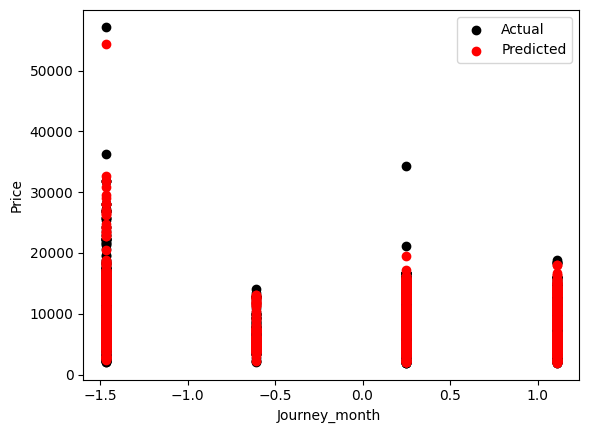

In [221]:
#plot predictions vs actual prices x axis duration y axis price
import matplotlib.pyplot as plt
plt.scatter(X_test['Journey_month'], y_test, color='black', label='Actual')
plt.scatter(X_test['Journey_month'], final_predictions, color='red', label='Predicted')
plt.xlabel('Journey_month ')
plt.ylabel('Price')
plt.legend()
plt.show()


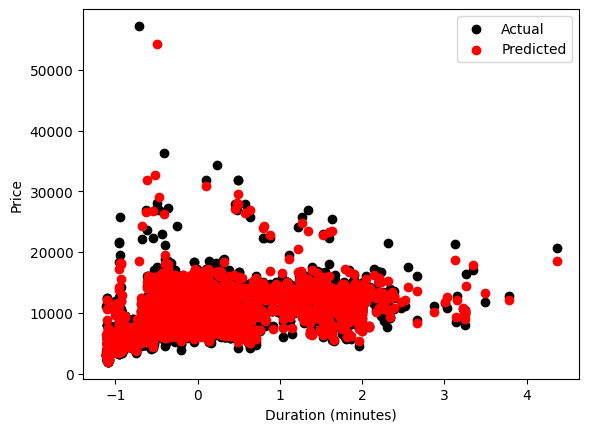

In [222]:
#plot predictions vs actual prices x axis duration y axis price
import matplotlib.pyplot as plt
plt.scatter(X_test['Duration'], y_test, color='black', label='Actual')
plt.scatter(X_test['Duration'], final_predictions, color='red', label='Predicted')
plt.xlabel('Duration (minutes)')
plt.ylabel('Price')
plt.legend()
plt.show()
